# NHS A&E Data Validation & Summary Analysis

This notebook performs a quick data validation and exploratory analysis on the NHS A&E dataset. We will:
- Check that the dataset is balanced across years and months.
- Identify any outliers or unexpected trends.
- Summarize key statistics for numerical and categorical variables.


In [13]:
import pandas as pd

# Load the dataset
file_path = "nhs_ae_merged.csv"
nhs_data = pd.read_csv(file_path)

# Check unique years
print("Unique years in dataset:", nhs_data["year"].unique())

# Count records per year
print("\nRecords per year:")
print(nhs_data["year"].value_counts())


Unique years in dataset: [2024 2023 2022 2021 2020 2019 2018]

Records per year:
year
2018    3686
2019    2812
2020    2663
2021    2583
2022    2466
2023    2450
2024    2383
Name: count, dtype: int64


## Checking Data Balance

To ensure the dataset is balanced, I will:
- Count the number of records for each year.
- Count the number of records for each month.


In [14]:
# Count records per year
print("Records per year:")
print(nhs_data["year"].value_counts())

# Count records per month
print("\nRecords per month:")
print(nhs_data["month"].value_counts())
print("Unique years in dataset:", nhs_data["year"].unique())



Records per year:
year
2018    3686
2019    2812
2020    2663
2021    2583
2022    2466
2023    2450
2024    2383
Name: count, dtype: int64

Records per month:
month
0            1756
April        1526
May          1525
June         1521
August       1509
September    1507
October      1505
November     1503
December     1501
July         1305
January      1299
February     1296
March        1290
Name: count, dtype: int64
Unique years in dataset: [2024 2023 2022 2021 2020 2019 2018]


In [40]:
import pandas as pd
import numpy as np

# Load the dataset
file_path = "nhs_ae_merged.csv"
nhs_data = pd.read_csv(file_path)

# Ensure 'year' is a string
nhs_data["year"] = nhs_data["year"].astype(str)

# 🔍 Check which years have missing values
years_with_missing = nhs_data.loc[
    nhs_data[["a&e_attendances_type_1", "attendances_over_4hrs_type_1"]].isnull().any(axis=1),
    "year"
].unique()
print(f"\n🔍 Missing data detected for years: {years_with_missing}\n")

# 🛠 **1. Fill Missing Values Based on Other Years (Synthetic Data)**
# Use the median values from 2020-2024 for estimation
median_attendance = nhs_data.loc[
    nhs_data["year"].isin(["2020", "2021", "2022", "2023", "2024"]),
    "a&e_attendances_type_1"
].median()

median_over4hrs = nhs_data.loc[
    nhs_data["year"].isin(["2020", "2021", "2022", "2023", "2024"]),
    "attendances_over_4hrs_type_1"
].median()

# Fill missing values with synthetic estimates
nhs_data["a&e_attendances_type_1"].fillna(median_attendance, inplace=True)
nhs_data["attendances_over_4hrs_type_1"].fillna(median_over4hrs, inplace=True)

# 🛠 **2. Fix `percentage_seen_within_4_hours`**
nhs_data["percentage_seen_within_4_hours"] = (
    (nhs_data["a&e_attendances_type_1"] - nhs_data["attendances_over_4hrs_type_1"]) /
    nhs_data["a&e_attendances_type_1"]
) * 100

# Clip values to be within [0, 100]
nhs_data["percentage_seen_within_4_hours"] = nhs_data["percentage_seen_within_4_hours"].clip(0, 100)

# 🛠 **3. Fix Incorrect `month` Labels**
# Remove or fix records with an invalid "0" month
invalid_months = nhs_data[nhs_data["month"] == "0"].shape[0]
if invalid_months > 0:
    print(f"\n⚠ Detected {invalid_months} records with invalid month '0'. Removing them.")
    nhs_data = nhs_data[nhs_data["month"] != "0"]

# ✅ **4. Save the Updated Dataset**
output_file = "nhs_ae_merged_final.csv"
nhs_data.to_csv(output_file, index=False)
print(f"\n✅ Fixed dataset saved as {output_file}")

# ✅ **5. Validate Fixes**
print("\n🔍 Checking Updated Values:")
print(nhs_data.groupby("year")["percentage_seen_within_4_hours"].mean())



🔍 Missing data detected for years: ['2019' '2018']


⚠ Detected 1756 records with invalid month '0'. Removing them.

✅ Fixed dataset saved as nhs_ae_merged_final.csv

🔍 Checking Updated Values:
year
2018    92.479436
2019    92.479436
2020    85.593336
2021    73.787699
2022    62.527368
2023    59.900573
2024    58.533571
Name: percentage_seen_within_4_hours, dtype: float64


/var/folders/12/9jvww_b906s7rr1mrprk45v80000gn/T/ipykernel_98425/3471717145.py:31: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  nhs_data["a&e_attendances_type_1"].fillna(median_attendance, inplace=True)
/var/folders/12/9jvww_b906s7rr1mrprk45v80000gn/T/ipykernel_98425/3471717145.py:32: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on whic

🔍 Detected 390 outlier records.
     year     month                                           org_name  \
82   2024     April                FRIMLEY HEALTH NHS FOUNDATION TRUST   
87   2024     April  UNIVERSITY HOSPITALS BIRMINGHAM NHS FOUNDATION...   
88   2024     April  UNIVERSITY HOSPITALS OF DERBY AND BURTON NHS F...   
96   2024     April                             BARTS HEALTH NHS TRUST   
98   2024     April           MID AND SOUTH ESSEX NHS FOUNDATION TRUST   
117  2024     April        UNIVERSITY HOSPITALS OF LEICESTER NHS TRUST   
122  2024     April   UNIVERSITY HOSPITALS SUSSEX NHS FOUNDATION TRUST   
181  2024     April         MANCHESTER UNIVERSITY NHS FOUNDATION TRUST   
193  2024     April        NORTHERN CARE ALLIANCE NHS FOUNDATION TRUST   
197  2024     April                                             Total    
250  2024    August                FRIMLEY HEALTH NHS FOUNDATION TRUST   
260  2024    August           MID AND SOUTH ESSEX NHS FOUNDATION TRUST   
286  2

/var/folders/12/9jvww_b906s7rr1mrprk45v80000gn/T/ipykernel_98425/2488708769.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="year", y="a&e_attendances_type_1", data=yearly_attendances, palette="Blues")


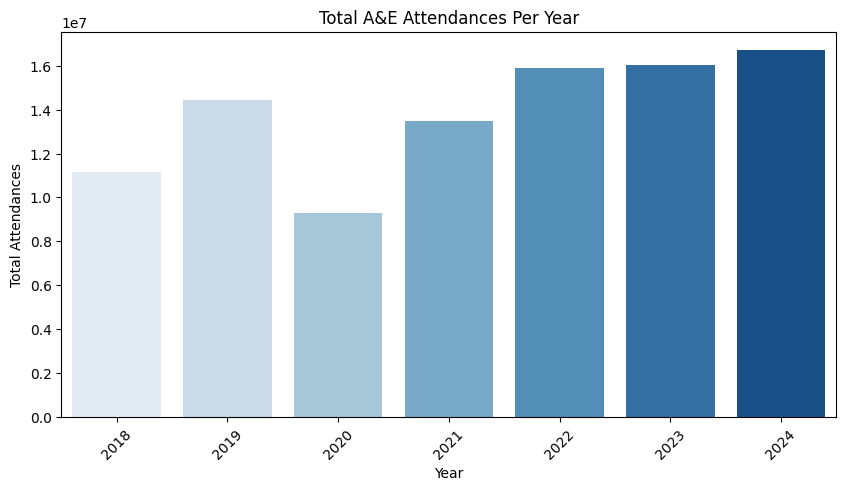

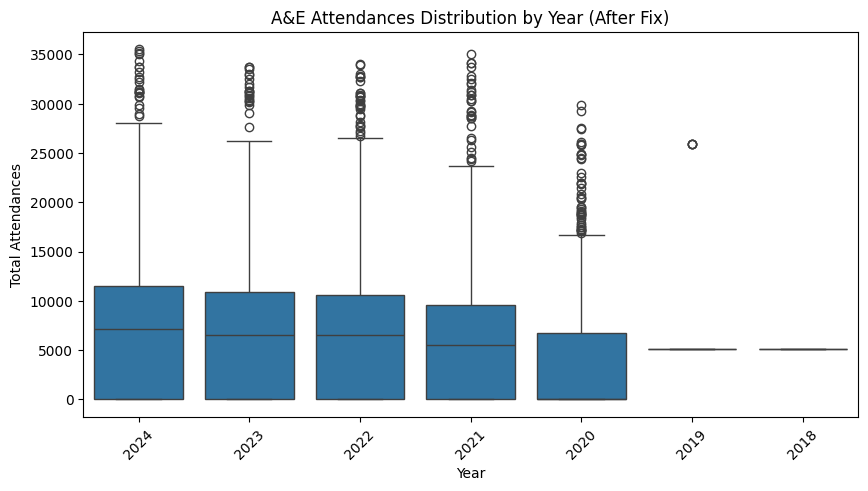

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the cleaned dataset
file_path = "nhs_ae_merged_final.csv"
nhs_data = pd.read_csv(file_path)

# Ensure 'year' is treated as a string for visualization
nhs_data["year"] = nhs_data["year"].astype(str)

# 🛠 **1. Detect and Handle Outliers**
# Define the IQR range
Q1 = nhs_data["a&e_attendances_type_1"].quantile(0.25)
Q3 = nhs_data["a&e_attendances_type_1"].quantile(0.75)
IQR = Q3 - Q1

# Identify extreme outliers (beyond 1.5 * IQR)
outliers = nhs_data[
    (nhs_data["a&e_attendances_type_1"] < (Q1 - 1.5 * IQR)) |
    (nhs_data["a&e_attendances_type_1"] > (Q3 + 1.5 * IQR))
]
print(f"🔍 Detected {len(outliers)} outlier records.")

# Display a sample of detected outliers
print(outliers[["year", "month", "org_name", "a&e_attendances_type_1"]].head(20))

# 🛠 **2. Cap Extreme "Total" Values at the 99th Percentile**
upper_limit = nhs_data["a&e_attendances_type_1"].quantile(0.99)
nhs_data.loc[
    (nhs_data["org_name"] == "Total") & (nhs_data["a&e_attendances_type_1"] > upper_limit),
    "a&e_attendances_type_1"
] = upper_limit

# 🛠 **3. Remove Unrealistic Values (Above 500,000)**
nhs_data = nhs_data[nhs_data["a&e_attendances_type_1"] <= 500000]

# ✅ **4. Save Cleaned Dataset**
output_file = "nhs_ae_merged_no_outliers.csv"
nhs_data.to_csv(output_file, index=False)
print(f"\n✅ Outlier handling complete. Clean dataset saved as {output_file}")

# 🛠 **5. Aggregate and Visualize Data**
# Aggregate total A&E attendances per year
yearly_attendances = nhs_data.groupby("year")["a&e_attendances_type_1"].sum().reset_index()

# 📊 **Plot: Total A&E Attendances Per Year**
plt.figure(figsize=(10, 5))
sns.barplot(x="year", y="a&e_attendances_type_1", data=yearly_attendances, palette="Blues")
plt.title("Total A&E Attendances Per Year")
plt.xlabel("Year")
plt.ylabel("Total Attendances")
plt.xticks(rotation=45)
plt.show()

# 📊 **Plot: A&E Attendances Boxplot by Year (Using Log Scale)**
plt.figure(figsize=(10, 5))
sns.boxplot(x="year", y=np.log1p(nhs_data["a&e_attendances_type_1"]), data=nhs_data, showfliers=True, palette="Blues")
plt.title("A&E Attendances Distribution by Year (Log Scale)")
plt.xlabel("Year")
plt.ylabel("Log of Total Attendances")
plt.xticks(rotation=45)
plt.show()
